<p>Ce projet se veut récupérer les données du dernier Vendée Globes 2021 et faire ressortir quelques résultats intéressants, comme l'impact du foil sur le classement des skippers.</p>
<p>Ce notebook se découpe en plusieurs parties :</p>
<ol> 
    <li>Récupération des données via scrapping sur différentes pages du site officielle de la course</li>
    <li>Regroupement des données par skipper avec pandas</li>
    <li>Analyse de l'impact du foil sur le classement des participants</li>
</ol>
<p>La troisème partie peut se réaliser avec la sauvegarde des deux Dataframes sous format .pkl<p>

<h1>Imports</h1>

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import uuid
import xlwings as xw
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<h1>1. Acquisition et chargement des données</h1>

In [4]:
URL = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
URL2 = "https://www.vendeeglobe.org/fr/classement"
URL3 = "https://www.vendeeglobe.org/fr/glossaire"

<p>Pour le scrapping la bibliothèque BeautifulSoup est utilisée.</p>

In [17]:
res = requests.get(URL2)
soup = BeautifulSoup(res.content)

def save_with_xlwings(file, new_name):
    tempfile = f'./{uuid.uuid1()}.xlsx'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(new_name)
    excel_book.close()
    excel_app.quit()
    return tempfile

#Récupération des excels, stockage dans le dossier datas et chargement des données avec xlwings dans le dossier xlwings
for option in soup.find_all("option")[1:]:
    response = requests.get(URL + option['value'] + '.xlsx')
    name = option['value'] + '.xlsx'
    open("datas/" + name, "wb").write(response.content)
    save_with_xlwings("datas/" + name, "datas_wing/" + name)

In [5]:
#Récupération des informations sur les bâteaux des participants
res = requests.get(URL3)
soup = BeautifulSoup(res.content)
boat_infos = [i.text for i in soup.find_all("ul", {"class":"boats-list__popup-specs-list"})]
skipper_names = [i.text.title() for i in soup.find_all("span", {"class":"boats-list__skipper-name"})]

<h1>2. Préparation des données</h1>

In [6]:
def create_dataframe(df):
    df = df.drop([('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], axis=1)
    df.columns = df.columns.get_level_values(1)
    df = df.rename(columns={"Unnamed: 1_level_1": "Rang", "Unnamed: 2_level_1": "Nat", "Unnamed: 3_level_1": "Skipper/Bateau", "Unnamed: 19_level_1": "DTF", "Unnamed: 20_level_1": "DTL"})
    df.columns.values[[i for i in range(6,10)]] = [df.columns.values[i].split('\n')[0] + "_30min" for i in range(6,10)]
    df.columns.values[[i for i in range(10,14)]] = [df.columns.values[i].split('\n')[0] + "_lastreport" for i in range(10,14)]
    df.columns.values[[i for i in range(14,18)]] = [df.columns.values[i].split('\n')[0] + "_24h" for i in range(14,18)]
    df.rename(columns=lambda c: c.split('\n')[0], inplace=True)
    df[['Skipper','Bateau']] = df["Skipper/Bateau"].str.split("\n",expand=True,)
    df = df.drop(columns=["Skipper/Bateau"], axis=1)
    return df

In [7]:
#création du dataframe des classements au cours de la course
dir_path = "datas_wing"
before_arrival = "20210127_140000"

df = pd.DataFrame(columns = ['Rang', 'Nat', 'Heure FR', 'Latitude', 'Longitude', 'Cap_30min',
       'Vitesse_30min', 'VMG_30min', 'Distance_30min', 'Cap_lastreport',
       'Vitesse_lastreport', 'VMG_lastreport', 'Distance_lastreport',
       'Cap_24h', 'Vitesse_24h', 'VMG_24h', 'Distance_24h', 'DTF', 'DTL',
       'Skipper', 'Bateau'])

for path in os.listdir(dir_path):
    if path.split("/")[0] < before_arrival:
        df = pd.concat([df, create_dataframe(pd.read_excel(dir_path + '/' + path, header=[3,4], nrows=33))], ignore_index=True)
    else: 
        break
df.to_pickle("classement.pkl")
df.head()

,Rang,Nat,Heure FR,Latitude,Longitude,Cap_30min,Vitesse_30min,VMG_30min,Distance_30min,Cap_lastreport,...,VMG_lastreport,Distance_lastreport,Cap_24h,Vitesse_24h,VMG_24h,Distance_24h,DTF,DTL,Skipper,Bateau
0,NaN,\nFRA 79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Charlie Dalin,APIVIA
1,NaN,\nFRA 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sébastien Simon,ARKEA PAPREC
2,NaN,\nFRA 30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clarisse Cremer,Banque Populaire X
3,NaN,\nFRA 18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Louis Burton,Bureau Vallée 2
4,NaN,\nFRA 50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miranda Merron,Campagne de France


In [8]:
#Création du Dataframe pour les bâteaux des participants
l = [i.split(" : ") for i in boat_infos[0].split('\n')[1:-1]]
names = [l[i][0] for i in range(len(l))]
values = [l[i][1] for i in range(len(l))]
df_boat = pd.DataFrame([values], columns=names)

for j in range(1, len(boat_infos)):
    l = [i.split(" : ") for i in boat_infos[j].split('\n')[1:-1]]
    names = [l[i][0] for i in range(len(l))]
    values = [l[i][1] for i in range(len(l))]
    new_df = pd.DataFrame([values], columns=names)
    df_boat = df_boat.merge(new_df, how='outer')
    
skipper_names = [skipper_names[i].title() for i in range(len(skipper_names))]
df_boat['Skipper'] = skipper_names
df_boat.to_pickle("bateaux.pkl")
df_boat.head()

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Skipper
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2,Fabrice Amedeo
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2,Romain Attanasio
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2,Alexia Barrier
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,Yannick Bestaven
4,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2,Jérémie Beyou


<h1>3. Analyse et story telling</h1>

In [82]:
#Sauvegarde des fichiers
df_boat = pd.read_pickle('bateaux.pkl')
df = pd.read_pickle('classement.pkl')

<h2>a. Aggrégation des données par pilote</h2>

In [83]:
df_new = df.drop(df.loc[df['Rang'] == 'RET'].index)
df_new = df_new.drop(df.loc[df['Rang'] == 'NL'].index)
df_new = df_new.dropna(subset=['Rang'])
df_new['VMG_lastreport'] = pd.to_numeric(df_new['VMG_lastreport'].apply(lambda c: c.split(' ')[0]))
df_new['Rang'] = pd.to_numeric(df_new['Rang'])
df_new.head()

,Rang,Nat,Heure FR,Latitude,Longitude,Cap_30min,Vitesse_30min,VMG_30min,Distance_30min,Cap_lastreport,...,VMG_lastreport,Distance_lastreport,Cap_24h,Vitesse_24h,VMG_24h,Distance_24h,DTF,DTL,Skipper,Bateau
33,1,\nFRA 18,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,...,0.0,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,Louis Burton,Bureau Vallée 2
34,2,\nMON 10,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,...,0.0,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,Boris Herrmann,Seaexplorer - Yacht Club De Monaco
35,3,\nFRA 8,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,...,0.0,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,Jérémie Beyou,Charal
36,4,\nFRA 59,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,...,0.0,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,Thomas Ruyant,LinkedOut
37,5,\nFRA 53,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,...,0.0,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,Maxime Sorel,V And B Mayenne


In [84]:
#Par skipper, on conserve le rang et la vitesse moyenne
df_group = df_new.groupby(['Skipper']).mean()
df_group.head()

,Rang,VMG_lastreport
Skipper,,
Alan Roura,16.340956,11.097089
Alex Thomson,7.461538,11.120513
Alexia Barrier,25.141372,9.511642
Ari Huusela,26.392931,9.376091
Armel Tripon,16.361746,12.234511


<h2>b. Régression linéaire entre le rang moyen et la vitesse moyenne</h2>

<p>Avec la visualisation de la vitesse moyenne en fonction du rang, on peut supposer une potentiel relation linéaire entre les deux, on teste : </p>

In [85]:
rang = df_group['Rang'].to_numpy()
vitesse = df_group['VMG_lastreport'].to_numpy()

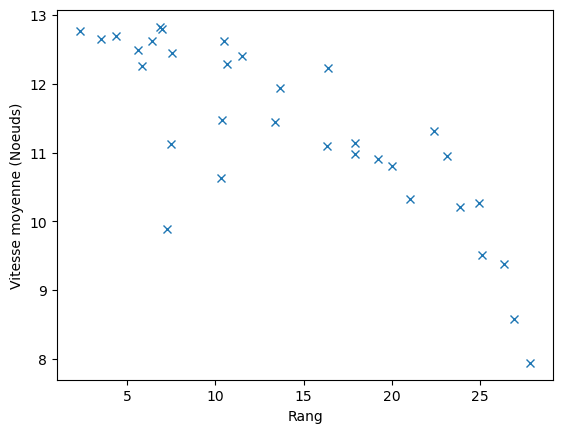

In [86]:
plt.plot(rang, vitesse, 'x')
plt.xlabel('Rang')
plt.ylabel('Vitesse moyenne (Noeuds)');

In [87]:
vitesse = vitesse.reshape(-1, 1)

reg = LinearRegression(fit_intercept=True).fit(vitesse, rang)
print(f'Le score de la régression est : {reg.score(vitesse, rang)}')

print(f'Les coeffs sont : {reg.coef_}')

print(f"L'intercept est : {reg.intercept_}")

Le score de la régression est : 0.6563014712531281
Les coeffs sont : [-4.94967259]
L'intercept est : 70.30830874826462


<p>La modélisation linéaire ne semble pas la plus adaptée avec un coefficient de corrélation de 0.66.</p>

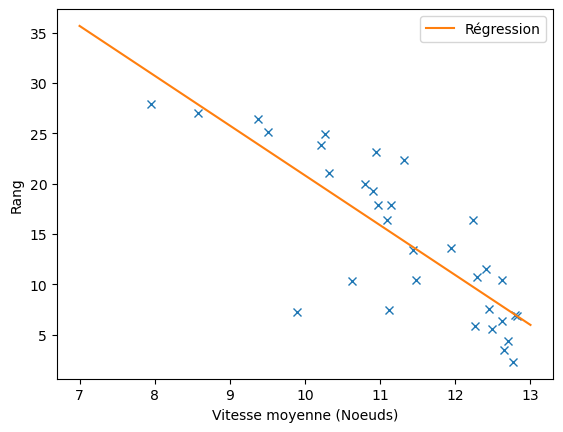

In [88]:
x = np.linspace(7,13,100)
y = reg.coef_[0]*x+reg.intercept_

plt.plot(vitesse, rang, 'x')
plt.plot(x, y, label='Régression')
plt.ylabel('Rang')
plt.xlabel('Vitesse moyenne (Noeuds)')
plt.legend();

<h2>c. Analyse de l'impact du foil sur le rang moyen et la vitesse moyenne</h2>

In [89]:
df_foil = df_group.reset_index().merge(df_boat)[['Nombre de dérives', 'Rang', 'VMG_lastreport']]
df_foil['Nombre de dérives'] = df_foil['Nombre de dérives'].map({'foils': True, 'foiler': True, '2 asymétriques': False, '2': False})
df_foil = df_foil.rename(columns={'Nombre de dérives': 'Foil'})
df_foil.shape

(30, 3)

In [90]:
foils = df_foil['Foil'].to_numpy()
inv_foils = np.invert(foils)
rang_foil = df_foil['Rang'].to_numpy()
vitesse_foil = df_foil['VMG_lastreport'].to_numpy()

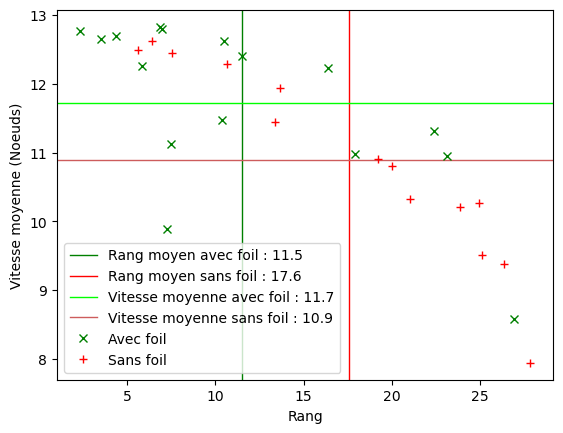

In [91]:
plt.axvline(x = rang_foil[foils].mean(), color = 'g', label = "Rang moyen avec foil : {0:.1f}".format(rang_foil[foils].mean()), linewidth=1.0)
plt.axvline(x = rang_foil[inv_foils].mean(), color = 'r', label = "Rang moyen sans foil : {0:.1f}".format(rang_foil[inv_foils].mean()), linewidth=1.0)

plt.axhline(vitesse_foil[foils].mean(), color = 'lime', label = "Vitesse moyenne avec foil : {0:.1f}".format(vitesse_foil[foils].mean()), linewidth=1.0)
plt.axhline(vitesse_foil[inv_foils].mean(), color = 'indianred', label = "Vitesse moyenne sans foil : {0:.1f}".format(vitesse_foil[inv_foils].mean()), linewidth=1.0)

plt.plot(rang_foil[foils], vitesse_foil[foils], 'x', color='g', label='Avec foil')
plt.plot(rang_foil[inv_foils], vitesse_foil[inv_foils], '+', color='r', label='Sans foil')

plt.xlabel('Rang')
plt.ylabel('Vitesse moyenne (Noeuds)')
plt.legend();

<p>Avec une représentation graphique rapide, on remarque bien que sans foil, les skippers sont en moyenne 6 places en-dessous d'un skipper avec foil et qu'ils sont moins rapides de 0.8 noeuds.</p>

In [92]:
df_foil['Foil'] = df_foil['Foil'].map({True: 1, False: 0})
X = df_foil[['VMG_lastreport', 'Foil']].to_numpy()

pca = PCA(n_components=2)
pca.fit(X)

print(f"Explained variance ratio : {pca.explained_variance_ratio_}")

print(f"Valeurs singulières de la SVD : {pca.singular_values_}")

Explained variance ratio : [0.88928077 0.11071923]
Valeurs singulières de la SVD : [7.30393716 2.57720579]


<p>On remarque, grâce à la réalisation d'une PCA sur les variables vitesse et moyenne et présence d'un foil, que la présence d'un foil est impliqué à 11% dans l'explication de la variance, de même la valeur singulière liée à la présence du foil est non négligeable.</p>

In [109]:
new_X = StandardScaler().fit_transform(X)
reg = LinearRegression(fit_intercept=True).fit(new_X, df_foil[["Rang"]].to_numpy())
print(f'Le score de la régression est : {reg.score(new_X, df_foil[["Rang"]].to_numpy())}')

print(f'Les coeffs sont : {reg.coef_}')

print(f"L'intercept est : {reg.intercept_}")

Le score de la régression est : 0.6988597796099956
Les coeffs sont : [[-6.3316765  -1.06262374]]
L'intercept est : [14.31213157]


<p>On effectue une régression linéaire en ajoutant la variable foil qui vaut 0 si le bâteau en est équippé sinon 1. Le coefficient de la vitesse est 6 fois plus important dans la prédiction du rang moyen d'un skipper. Cette étude montre aussi l'importance du foil sur le rang moyen des voiliers bien que la vitesse soit 6 fois plus importante dans cette prédiction.</p>
<p>Le coefficient de détermination est aussi légèrement meilleur que pour la régression linéaire sans la variable foil.</p>

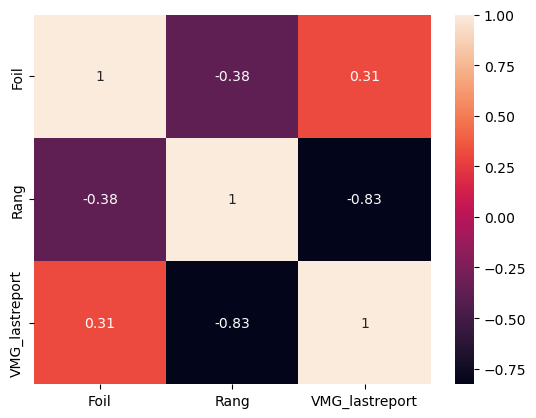

In [114]:
cor = df_foil.corr()
sns.heatmap(cor, annot=True);

<p>On remarque avec a matrice de corrélation que la vitesse et le Rang sont effectivement assez corrélé à hauteur de 83%, c'est moins le cas pour la présence d'un foil avec le rang ou la vitesse.</p>

<h2>d. Prise en compte de toutes les features des bâteaux</h2>

In [238]:
df_bat = df_group.reset_index().merge(df_boat)[['Rang', 'VMG_lastreport', 'Longueur', 'Largeur', "Tirant d'eau",
       'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât',
       'Voile quille', 'Surface de voiles au près',
       'Surface de voiles au portant']]
df_bat['Nombre de dérives'] = df_bat['Nombre de dérives'].map({'foils': 1, 'foiler': 1, '2 asymétriques': 0, '2': 0})
df_bat = df_bat.rename(columns={'Nombre de dérives': 'Foil'})

In [239]:
def set_split(name):
    name = name.apply(lambda c: c.split(' ')[0])
    name = name.apply(lambda c: c.split('m')[0])
    name = name.apply(lambda c: c.replace('t', ''))
    name = name.apply(lambda c: c.replace(',', '.'))
    name = name.apply(lambda c: c.replace('NC', '0'))
    return pd.to_numeric(name) 

df_bat[['Longueur', 'Largeur', "Tirant d'eau", 'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']] = df_bat[['Longueur', 'Largeur', "Tirant d'eau", 'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']].apply(set_split)
df_bat['Déplacement (poids)'].loc[df_bat['Déplacement (poids)']==0] = df_bat['Déplacement (poids)'].mean()
df_bat['Voile quille'].loc[df_bat['Voile quille']=='acier mécano soudé'] = 'Acier mécano soudé'

df_bat.head()

C:\Users\antoi\AppData\Local\Temp\ipykernel_14628\1625581510.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['Déplacement (poids)'].loc[df_bat['Déplacement (poids)']==0] = df_bat['Déplacement (poids)'].mean()
C:\Users\antoi\AppData\Local\Temp\ipykernel_14628\1625581510.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['Voile quille'].loc[df_bat['Voile quille']=='acier mécano soudé'] = 'Acier mécano soudé'


,Rang,VMG_lastreport,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Foil,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,7.461538,11.120513,18.28,5.40,4.5,7.7,1,29.0,acier forgé,330,630
1,25.141372,9.511642,18.28,5.54,4.5,9.0,0,29.0,acier,260,580
2,26.392931,9.376091,18.28,5.80,4.5,8.5,0,28.0,acier,270,580
3,16.361746,12.234511,18.28,5.50,4.5,7.8,1,28.0,acier forgé,270,535
4,7.542620,12.452599,18.28,5.85,4.5,8.0,0,29.0,acier forgé,300,700


In [240]:
y = pd.get_dummies(df_bat['Voile quille'])
df_bat = df_bat.merge(y, left_index=True, right_index=True)
df_bat = df_bat.drop(['Voile quille'], axis=1)
df_bat.head()

,Rang,VMG_lastreport,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Foil,Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Acier mécano soudé,Inox usiné,acier,acier forgé,basculante sur vérin hydraulique,carbone,monotype
0,7.461538,11.120513,18.28,5.40,4.5,7.7,1,29.0,330,630,0,0,0,1,0,0,0
1,25.141372,9.511642,18.28,5.54,4.5,9.0,0,29.0,260,580,0,0,1,0,0,0,0
2,26.392931,9.376091,18.28,5.80,4.5,8.5,0,28.0,270,580,0,0,1,0,0,0,0
3,16.361746,12.234511,18.28,5.50,4.5,7.8,1,28.0,270,535,0,0,0,1,0,0,0
4,7.542620,12.452599,18.28,5.85,4.5,8.0,0,29.0,300,700,0,0,0,1,0,0,0


In [244]:
new_X = StandardScaler().fit_transform(df_bat.to_numpy()[:,1:])
reg_bat = LinearRegression(fit_intercept=True).fit(new_X, df_bat["Rang"].to_numpy())
print(f'Le score de la régression est : {reg_bat.score(new_X, df_bat[["Rang"]].to_numpy())}')

print(f'Les coeffs sont : {reg_bat.coef_}')

print(f"L'intercept est : {reg_bat.intercept_}")

Le score de la régression est : 0.8420709624859007
Les coeffs sont : [-7.06227861e+00 -6.66133815e-15  5.54111499e-01 -6.21724894e-15
 -4.78319111e-02  4.31843576e-01 -6.27586832e-01 -5.64284842e-01
 -3.19825531e-01  3.36383820e+00  2.37995581e+00  8.47876110e+00
  8.73870384e+00  3.20284532e+00  5.32076568e+00  3.97029636e+00]
L'intercept est : 14.312131567863986


<p>Le coefficient de détermination est bien plus élevé que pour la précédente régréssion ou seul 2 features avaient été utilisés. On remarque que plusieurs variables peuvent aussi expliqués le rang, autre que la vitesse, le type de voile quille est presque aussi important.</p>